In [1]:
import os
import random

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# 特徴量選択
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    VarianceThreshold,
    RFE,
    RFECV,
)
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

# config python file
import config

# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

In [2]:
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# seedの固定
def fix_seed(seed: int):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)


# 再現性をもたせるためのseed固定
SEED = config.SEED
fix_seed(SEED)

# データ読み込み

In [3]:
X = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X.pkl")
y = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/y.pkl")


X_train_chi2 = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_chi2.pkl"
)
X_test_chi2 = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_chi2.pkl"
)

X_train_ANOVA = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_ANOVA.pkl"
)
X_test_ANOVA = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_ANOVA.pkl"
)

X_train_chi2_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_chi2_norm.pkl"
)
X_test_chi2_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_chi2_norm.pkl"
)

X_train_ANOVA_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_ANOVA_norm.pkl"
)
X_test_ANOVA_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_ANOVA_norm.pkl"
)

y_train = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/y_train.pkl"
)
y_test = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/y_test.pkl"
)

# 評価指標

In [4]:
# 基本的なスコアの表示（面倒なので関数化した）
def show_scores(y_test: pd.Series, y_pred: pd.Series):
    print("accuracy: ", accuracy_score(y_test, y_pred))
    print("precision: ", precision_score(y_test, y_pred))
    print("recall: ", recall_score(y_test, y_pred))
    print("f1 score: ", f1_score(y_test, y_pred))


# 混合行列のプロット
def plot_confusion_matrix(
    y_test: pd.Series,
    y_pred: pd.Series,
    model_name: str = "confusion matrix",
    display_details: bool = False,
):
    cm = confusion_matrix(y_test, y_pred, normalize="all", labels=[True, False])
    df_cm = pd.DataFrame(data=cm, index=[True, False], columns=[True, False])

    fig = plt.figure()
    sns.heatmap(df_cm, square=True, cbar=True, annot=True, cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.plot()

    if display_details:
        tn, fp, fn, tp = cm.ravel()
        print("tn: ", tn, "\nfp: ", fp, "\nfn:", fn, "\ntp:", tp)
        show_scores(y_test, y_pred)

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    1076
True      344
Name: target_OS_5years, dtype: int64

False    347
True     127
Name: target_OS_5years, dtype: int64

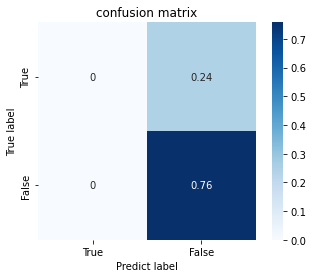

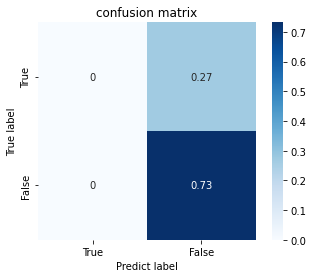

In [5]:
# trainのベースライン
y_train_base = pd.Series([False for i in range(y_train.shape[0])], index=y_train.index)
display(y_train.value_counts())
plot_confusion_matrix(y_train, y_train_base)
# testのベースライン（本命）
y_test_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
plot_confusion_matrix(y_test, y_test_base)

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

In [6]:
# 比較する2値分類器の設定
bcm_names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "Polynomial SVM",
    "RBF SVM",
    "Sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    # "Linear Discriminant Analysis", # predictメソッドに対応していない
    "Quadratic Discriminant Analysis",
]

classifiers = [
    LogisticRegression(max_iter=2000),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    # LDA(),
    QDA(),
]

## 複数の学習器の精度比較

In [7]:
def compare_bcms(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    sort_column_name: str = "f1_test",
    folds: int = 5,
    test_size: float = 0.25,
    over_sampling_class=None,
    normalization: bool = False,
    plot_cfmatrix=False,
):
    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for name, clf in tqdm(zip(bcm_names, classifiers)):  # 指定した複数の分類機を順番に呼び出す
        # print(name)  # モデル名
        kf = KFold(n_splits=folds, shuffle=True, random_state=SEED)
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            # print("initsize: ", X_train.shape)
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            if normalization:
                # trainデータにtestデータの内容を含ませないようにするため、MiMaxScaler()のsetを適用するのはtrainデータのみ
                mm = MinMaxScaler()
                mm.fit(X_train)
                X_train = pd.DataFrame(
                    mm.transform(X_train), index=X_train.index, columns=X_train.columns
                )

                X_test = pd.DataFrame(
                    mm.transform(X_test), index=X_test.index, columns=X_test.columns
                )

            # オーバーサンプリング（trainデータのみに適用）
            if over_sampling_class:
                X_train, y_train = over_sampling_class.fit_resample(X_train, y_train)
            # print("over sampling size: ", X_train.shape)

            # 訓練のスコア
            clf.fit(X_train, y_train)  # 学習
            y_pred_train = clf.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred_train)
            f1_train = f1_score(y_train, y_pred_train)
            # 　予測値のスコア
            y_pred = clf.predict(X_test)
            acc_test = accuracy_score(y_test, y_pred)  # 正解率（test）の算出
            f1_test = f1_score(y_test, y_pred)
            result.append([name, acc_train, acc_test, f1_train, f1_test])  # 結果の格納
        # 混合行列の表示
        if plot_cfmatrix:
            plot_confusion_matrix(y_test, y_pred)

    # 表示設定
    df_result = pd.DataFrame(
        result, columns=["classifier", "acc_train", "acc_test", "f1_train", "f1_test"]
    )
    df_result_mean = (
        df_result.groupby("classifier")
        .mean()
        .sort_values(sort_column_name, ascending=False)
    )
    warnings.filterwarnings("always")
    return df_result_mean

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_64300/393780517.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


## 学習曲線可視化

現状の精度の原因が**過学習**なのか**未学習**なのか、などなどを推測し、PDCAを回すために学習とそれに伴う精度の推移を可視化する

In [8]:
def plot_learning_curve(
    X: pd.DataFrame(),
    y: pd.DataFrame(),
    estimator: callable,
    over_sampling_class=None,
    cv: int = 10,
    train_sizes: np.arange = np.arange(100, 1001, 100),
):
    print(estimator)
    if over_sampling_class:
        X, y = over_sampling_class.fit_resample(X, y)
    # cvにintを渡すと k-foldの「k」を指定できる
    # ↓では3にしているので、3-fold法を使用する。
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        train_sizes=train_sizes,
        random_state=SEED,
        shuffle=True,
    )

    """
    print("train_sizes(検証したサンプル数): {}".format(train_sizes))
    print("------------")
    print("train_scores(各サンプル数でのトレーニングスコア): \n{}".format(train_scores))
    print("------------")
    print("test_scores(各サンプル数でのバリデーションスコア): \n{}".format(test_scores))
    """

    # 学習の様子をプロット
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Traing score と Test score をプロット
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Test score")

    # 標準偏差の範囲を色付け
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        color="r",
        alpha=0.2,
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        color="g",
        alpha=0.2,
    )

    plt.ylim(0.5, 1.0)
    plt.legend(loc="best")

    plt.show()

In [9]:
# 2値分類機の性能比較（パラメータ：デフォルト）
# compare_bcms(X, y)

## 特徴量抽出した各データでの精度比較

### χ^2検定

In [10]:
# 2値分類機の性能比較（特徴量抽出手法：chi2、パラメータ：デフォルト）
display(compare_bcms(X_train_chi2, y_train))
display(compare_bcms(X_train_chi2_norm, y_train))
display(
    compare_bcms(X_train_chi2, y_train, over_sampling_class=SMOTE(random_state=SEED))
)
display(
    compare_bcms(
        X_train_chi2_norm, y_train, over_sampling_class=SMOTE(random_state=SEED)
    )
)

11it [00:11,  1.01s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.683099,0.682394,0.461185,0.454861
Polynomial SVM,0.971479,0.709155,0.937798,0.306241
Decision Tree,1.000000,0.640141,1.000000,0.289701
AdaBoost,0.839085,0.722535,0.591747,0.283973
Nearest Neighbors,0.799648,0.726056,0.474360,0.268679
Logistic Regression,0.796303,0.740141,0.393385,0.229833
Random Forest,1.000000,0.752113,1.000000,0.158440
Linear SVM,0.793662,0.738028,0.332557,0.154664
Sigmoid SVM,0.742254,0.740141,0.133077,0.131482


11it [00:05,  1.94it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.680634,0.682394,0.466606,0.465152
Quadratic Discriminant Analysis,0.831690,0.690845,0.699042,0.387618
AdaBoost,0.826585,0.720423,0.563319,0.281389
Decision Tree,1.000000,0.646479,1.000000,0.280503
Polynomial SVM,0.918662,0.718310,0.804160,0.275773
Nearest Neighbors,0.798063,0.727465,0.451575,0.259058
Sigmoid SVM,0.674120,0.671831,0.251069,0.241138
Logistic Regression,0.778169,0.755634,0.282969,0.208501
Random Forest,1.000000,0.751408,1.000000,0.160804


11it [00:17,  1.64s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.657156,0.669014,0.642272,0.459591
Logistic Regression,0.747414,0.645070,0.752516,0.423532
Linear SVM,0.769462,0.626761,0.778064,0.410887
Nearest Neighbors,0.683664,0.391549,0.757903,0.397035
RBF SVM,0.905550,0.705634,0.906538,0.384251
AdaBoost,0.827461,0.633803,0.831614,0.371393
Sigmoid SVM,0.576917,0.669718,0.482123,0.364431
Polynomial SVM,0.995012,0.680282,0.995028,0.351795
Random Forest,1.000000,0.730986,1.000000,0.346244


11it [00:10,  1.06it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.663556,0.669718,0.654598,0.468653
Logistic Regression,0.705523,0.642958,0.712546,0.452601
Linear SVM,0.709004,0.633803,0.720763,0.449409
RBF SVM,0.876479,0.697183,0.880154,0.422695
Nearest Neighbors,0.738080,0.458451,0.790249,0.390037
AdaBoost,0.799552,0.622535,0.806577,0.379711
Quadratic Discriminant Analysis,0.868993,0.701408,0.871076,0.364915
Sigmoid SVM,0.513801,0.503521,0.521567,0.350038
Polynomial SVM,0.962002,0.649296,0.962919,0.338122


In [11]:
# 学習データ数
X_train_chi2_norm.shape

(1420, 70)

LogisticRegression(max_iter=2000)


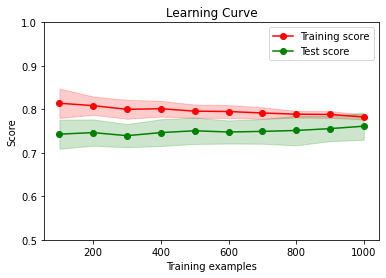

KNeighborsClassifier()


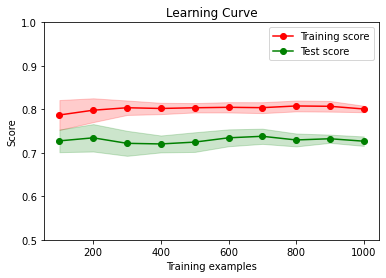

SVC(kernel='linear')


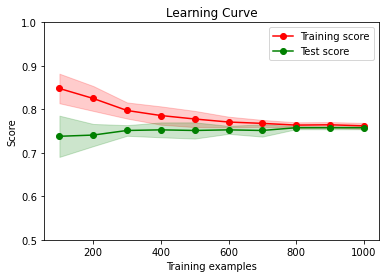

SVC(kernel='poly')


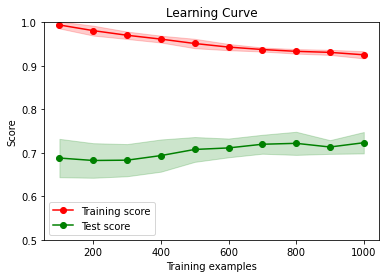

SVC()


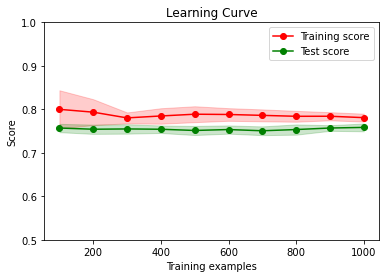

SVC(kernel='sigmoid')


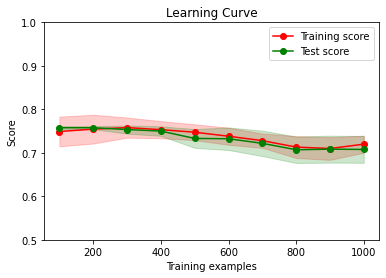

DecisionTreeClassifier()


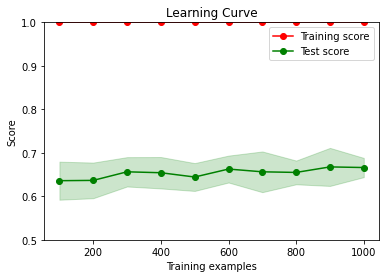

RandomForestClassifier()


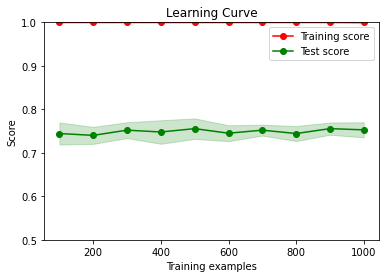

AdaBoostClassifier()


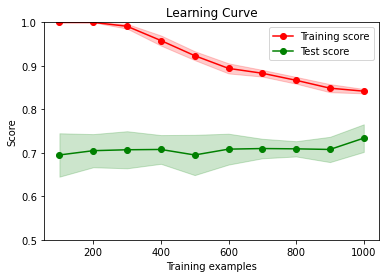

GaussianNB()


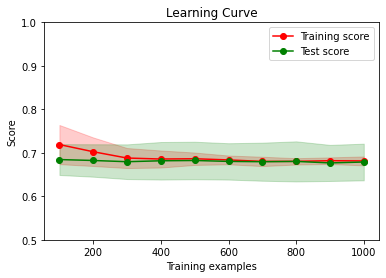

QuadraticDiscriminantAnalysis()


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/

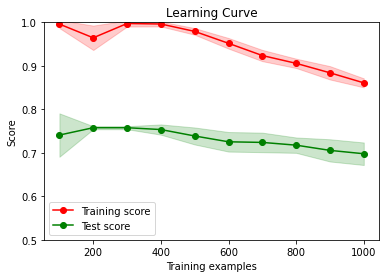

In [12]:
# chi2にて特徴量選択したデータを元に、各モデルでの学習曲線を可視化
# 正規化したほうが全体的に精度が高かったので、そちらを使用
for estimator in classifiers:
    plot_learning_curve(
        X_train_chi2_norm,
        y_train,
        estimator,
        cv=10,
        train_sizes=np.arange(100, int(len(X_train_chi2) * 0.75), 100),
    )

### ANOVA

In [13]:
# 2値分類機の性能比較（特徴量抽出手法：ANOVA、パラメータ：デフォルト）
display(compare_bcms(X_train_ANOVA, y_train))
display(compare_bcms(X_train_ANOVA_norm, y_train))
display(
    compare_bcms(X_train_ANOVA, y_train, over_sampling_class=SMOTE(random_state=SEED))
)
display(
    compare_bcms(
        X_train_ANOVA_norm, y_train, over_sampling_class=SMOTE(random_state=SEED)
    )
)

11it [00:12,  1.13s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.688908,0.687324,0.472282,0.466552
Quadratic Discriminant Analysis,0.848944,0.714789,0.681919,0.372188
Decision Tree,1.000000,0.659859,1.000000,0.333707
AdaBoost,0.826408,0.738732,0.544661,0.300479
Polynomial SVM,0.868486,0.733803,0.652275,0.271593
Nearest Neighbors,0.797359,0.741549,0.431073,0.240203
Logistic Regression,0.772887,0.750704,0.296582,0.234812
Random Forest,1.000000,0.750000,1.000000,0.166761
Linear SVM,0.757746,0.757746,0.000000,0.000000


11it [00:05,  2.03it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.688908,0.687324,0.472282,0.466552
Quadratic Discriminant Analysis,0.848944,0.714789,0.681919,0.372188
Decision Tree,1.000000,0.654225,1.000000,0.326311
AdaBoost,0.826408,0.738732,0.544661,0.300479
Polynomial SVM,0.895423,0.729577,0.730451,0.289779
Nearest Neighbors,0.793486,0.746479,0.423077,0.256052
Logistic Regression,0.768838,0.752113,0.233821,0.192326
Random Forest,1.000000,0.752113,1.000000,0.176368
RBF SVM,0.782218,0.756338,0.184350,0.061361


11it [00:18,  1.64s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.665022,0.678873,0.653022,0.482488
Logistic Regression,0.684982,0.653521,0.684376,0.454546
RBF SVM,0.701038,0.665493,0.695103,0.450091
Linear SVM,0.686970,0.645775,0.687933,0.449863
Sigmoid SVM,0.500000,0.242254,0.666667,0.389026
Nearest Neighbors,0.791229,0.497183,0.825009,0.377823
Random Forest,1.000000,0.720423,1.000000,0.374526
AdaBoost,0.779704,0.616197,0.786956,0.374029
Polynomial SVM,0.892809,0.650704,0.896881,0.368404


11it [00:11,  1.06s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.663866,0.680282,0.651779,0.483552
Logistic Regression,0.679216,0.650000,0.679936,0.458012
Linear SVM,0.683861,0.647887,0.685860,0.451884
RBF SVM,0.816811,0.689437,0.814645,0.430460
Sigmoid SVM,0.532116,0.350000,0.654292,0.391947
Nearest Neighbors,0.764202,0.478169,0.806548,0.380072
AdaBoost,0.781254,0.618310,0.787983,0.367782
Random Forest,1.000000,0.716197,1.000000,0.367677
Polynomial SVM,0.930826,0.645070,0.932354,0.320559


In [14]:
# 学習データ数
X_train_ANOVA_norm.shape

(1420, 45)

LogisticRegression(max_iter=2000)


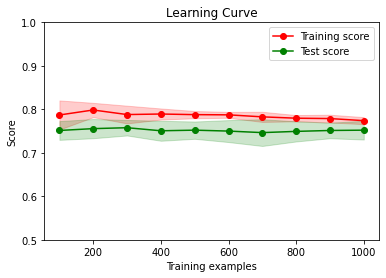

KNeighborsClassifier()


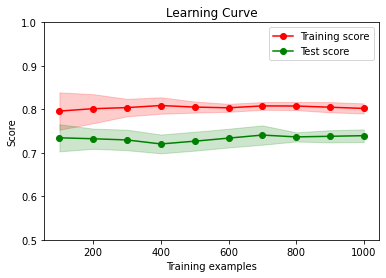

SVC(kernel='linear')


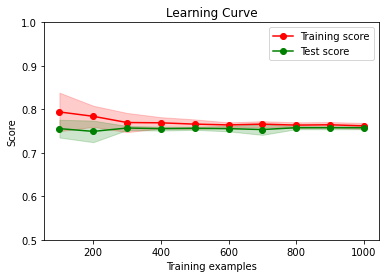

SVC(kernel='poly')


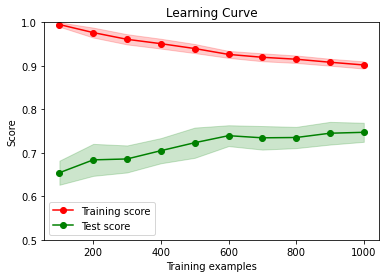

SVC()


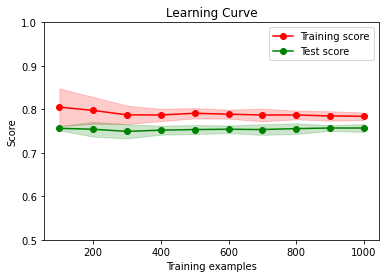

SVC(kernel='sigmoid')


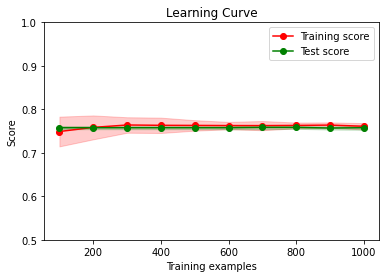

DecisionTreeClassifier()


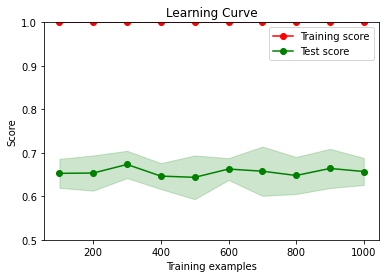

RandomForestClassifier()


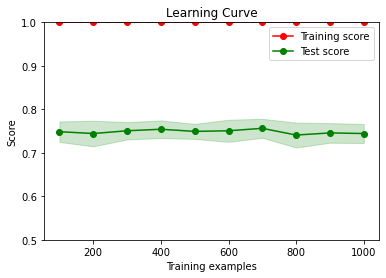

AdaBoostClassifier()


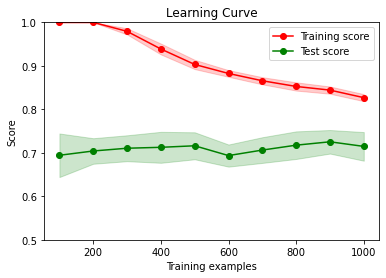

GaussianNB()


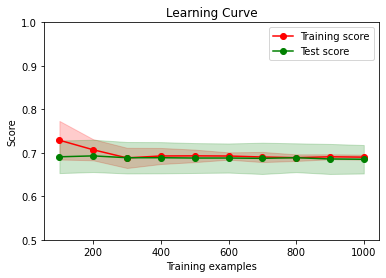

QuadraticDiscriminantAnalysis()


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/

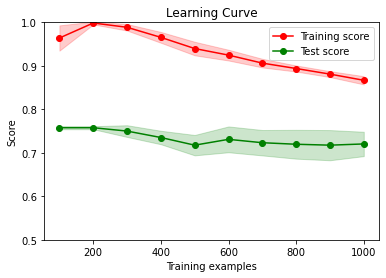

In [15]:
# chi2にて特徴量選択したデータを元に、各モデルでの学習曲線を可視化
# 正規化したほうが全体的に精度が高かったので、そちらを使用
for estimator in classifiers:
    plot_learning_curve(
        X_train_ANOVA_norm,
        y_train,
        estimator,
        cv=10,
        train_sizes=np.arange(100, int(len(X_train_chi2) * 0.75), 100),
    )

In [16]:
%time
"""
# 全ての遺伝子データを使用するととても時間がかかる
# 元のデータを元に、各モデルでの学習曲線を可視化
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X.shape, X_train.shape, X_test.shape

for estimator in classifiers:
    plot_learning_curve(
        X_train,
        y_train,
        estimator,
        train_sizes=np.arange(100, int(len(X_train_chi2) * 0.75), 100),
    )

"""

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 4.29 µs


'\n# 全ての遺伝子データを使用するととても時間がかかる\n# 元のデータを元に、各モデルでの学習曲線を可視化\nX_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)\nX.shape, X_train.shape, X_test.shape\n\nfor estimator in classifiers:\n    plot_learning_curve(\n        X_train,\n        y_train,\n        estimator,\n        train_sizes=np.arange(100, int(len(X_train_chi2) * 0.75), 100),\n    )\n\n'

# Wrapper メソッド

## SFS(Sequential Feature Selection): 逐次特徴選択

https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d

In [17]:
X_train_chi2.shape

(1420, 165)

In [ ]:
# Forward Selection
%time

sel = VarianceThreshold()

# ランダムフォレストを使う
rf = RandomForestClassifier()

selector = SequentialFeatureSelector(
    rf, n_features_to_select=50, cv=5
)  # Backwardと共通関数で、Defaultがfoward

X_train_front_selected = pd.DataFrame(
    selector.fit_transform(X_train_chi2, y_train),
    columns=X_train_chi2.columns.values[selector.get_support()],
)
result = pd.DataFrame(
    selector.get_support(),
    index=X_train_chi2.columns.values,
    columns=["False: dropped"],
)
print(result)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


In [ ]:
X_train_front_selected

In [ ]:
# 2値分類機の性能比較（パラメータ：デフォルト）
compare_bcms(X_train_front_selected, y_train)

In [ ]:
%%time
selector = SequentialFeatureSelector(
    rf, n_features_to_select=30, direction="backward", cv=5
)

X_train_back_selected = pd.DataFrame(
    selector.fit_transform(X_train_front_selected, y_train),
    columns=X_train_front_selected.columns.values[selector.get_support()],
)
result = pd.DataFrame(
    selector.get_support(),
    index=X_train_front_selected.columns.values,
    columns=["False: dropped"],
)
print(result)

In [ ]:
# 2値分類機の性能比較（パラメータ：デフォルト）
compare_bcms(X_train_back_selected, y_train)

In [ ]:
# chi2にて特徴量選択したデータを元に、各モデルでの学習曲線を可視化
for estimator in classifiers:
    plot_learning_curve(
        X_train_back_selected,
        y_train,
        estimator,
        train_sizes=np.arange(100, int(len(X_train_chi2) * 0.75), 100),
    )

# RFE

1. 全特徴量で訓練しモデルを生成
2. 最低のFeature Importnace/ Coef の特徴量を1つ減らして訓練しモデルを生成
3. 2のステップを残す特徴量の数に達するまで繰り返し

In [ ]:
%%time
selector = RFE(rf, n_features_to_select=8)


X_train_rfe = pd.DataFrame(
    selector.fit_transform(X_train_chi2, y_train),
    columns=X_train_chi2.columns.values[selector.get_support()],
)
result = pd.DataFrame(
    selector.get_support(),
    index=X_train_chi2.columns.values,
    columns=["False: dropped"],
)
result["ranking"] = selector.ranking_
print(result)

In [ ]:
display(compare_bcms(X_train_rfe, y_train))
# chi2にて特徴量選択したデータを元に、各モデルでの学習曲線を可視化
for estimator in classifiers:
    plot_learning_curve(
        X_train_rfe,
        y_train,
        estimator,
        train_sizes=np.arange(100, int(len(X_train_chi2) * 0.75), 100),
    )